In [ ]:
# hide
%load_ext autoreload
%autoreload 2

# Simple Walkthrough

> This tutorial provides a brief demonstration of py_clone_detective's core functionality. For a more detailed walkthrough, please see individual tutorials.

## Background

### Example Dataset

The example dataset used in this tutorial contains 2D immunofluorescence images of the *Drosophila* intestine obtained using a spinning-disc confocal microscope. The dataset is describes a "MARCM" experiment from the following [paper](https://doi.org/10.1016/j.celrep.2020.108423).

MARCM is a genetic technique whereby mitotic recombination generates GFP-marked homozygous mutant cells from heterozygous precursors. Over time, individually marked cells divide adjacent to each other and create "clones" of mutant cells, surrounded by unmarked wild-type cells:

<img src="docs/images/marcm_explanation.png" width=800>

> Left: Genetic labelling by MARCM. Right: Labelled cells grow over time into 'clones'.

In this dataset, intestines were imaged using four channels:
- C0 : DAPI (nuclear marker)
- C1 : GFP (clone marker)
- C2 : PDM1 staining (EnteroCyte marker)
- C3 : Prospero staining (EndoEndocrine marker)

<img src="docs/images/marcm_slide2-01.png" width=400>

> composite image

### Experimental Aim

Dataset images contain cells positive for an EnteroCyte marker, cells positive for an EnteroEndocrine marker, and cells negative for both - stem/progenitor cells.

We aim to:
* Quantify the number and type of cells present in each image.
* Classify whether each cell resides outside or inside a clone.

As only cells inside a clone are mutant for our gene of interest, we can determine if our gene of interest regulates **cell differentiation** by comparing the percentage of each cell type inside vs. outside a clone. We can measure if our gene of interest regulates **cell proliferation** by comparing the number of cells per mutant clone, to the number of cells per control clone i.e. clones generated in wild-type animals lacking any mutation.

## Walkthrough

### Initiate Dask dashboard (optional)

Most functions in py_clone_detector are parallelised using [Dask](https://dask.org/). When using the Dask distributed scheduler, we can access an interactive dashboard that details our computations' status, progress, and history. While especially useful when working on a remote cluster, the interactive dashboard is a great addition even when working locally (e.g. MacBook).

For example, here is what the dashboard looks like when measuring cell properties using the `CloneCounter.make_measurements()` call described below. Each line of the 'Task Stream' corresponds to one of 8 logical cores on my MacBook Pro.

![SegmentLocal](docs/images/dask.gif "dask")
> example Dask dashboard

**N.B.** Initiating a Dask scheduler is optional when working on your local machine. If you don't launch one, all computations will still run; you just won't have access to the fancy dashboard!

Launch the scheduler as follows on your local machine and click on the dashboard link:

In [ ]:
from dask.distributed import Client

c = Client()
c

<img src="docs/images/client_setup.png">

If you're working on a remote cluster, e.g. a SLURM HPC, please see the relevant [Dask guides](https://jobqueue.dask.org/en/latest/index.html).

### Import and instantiate CloneCounter subclass:

The LazyCloneCounter subclass uses Dask to lazy load image series that may be too large to fit in RAM. If your data is small enough to fit into RAM, you can speed things up using the PersistentCloneCounter subclass. 

For more details, see the advanced tutorial (coming soon).

In [ ]:
from py_clone_detective.clone_counters import LazyCloneCounter

We intialise a LazyCloneCounter with four required arguments:

- **exp_name** : str -> name of the experiment
- **img_name_regex** : str -> regular expression used to extract unique identifies from image filenames
- **pixel_size** : str -> pixel size in $\mu m^{2}$
- **tot_seg_ch** : str -> image channel used to define the total number of cells e.g. DAPI channel.

In this experiment, images using the following pattern:
- *'a1'* if from a wild-type animal. *'a2'* if from a mutant animal.
- *'g01'* for gut 1. *'g02'* for gut 2 etc.
- *'p1'* for position 1. *'p2'* for position 2 etc.

Image names such as *'a1g01p1'* can thus be parsed using the regular expression "a\dg\d\dp\d".

In [ ]:
exp = LazyCloneCounter(
    exp_name="Marcm2a_E7F1",
    img_name_regex=r"a\dg\d\dp\d",
    pixel_size=0.275,
    tot_seg_ch="C0",
)

### Load images and segmentations

We add images to the LazyCloneCounter instance by passing a filename "glob" for each of the image channel. For example, the directory "data/MARCM_experiment/images/C0/" contains a series of tif images for the C0 channel:

In [ ]:
import os

# show the first 5 files in the directory
os.listdir("data/MARCM_experiment/images/C0/")[:5]

['a2g09p2.tif', 'a2g10p3.tif', 'a2g12p1.tif', 'a1g04p1.tif', 'a2g10p2.tif']

In this experiment, tifs for each image channel (C0, C1, C2 and C3) are stored in four separate folders.

In [ ]:
exp.add_images(
    C0="data/MARCM_experiment/images/C0/*.tif",
    C1="data/MARCM_experiment/images/C1/*.tif",
    C2="data/MARCM_experiment/images/C2/*.tif",
    C3="data/MARCM_experiment/images/C3/*.tif",
)

Our image data is stored in a [Xarray DataSet](http://xarray.pydata.org/en/stable/user-guide/data-structures.html), which is a collection of Xarray DataArrays, each containing Numpy or dask arrays with explicitly labelled **dimensions** and **coordinates**:

In [ ]:
exp.image_data

,Array,Chunk
Bytes,335.38 MiB,1.25 MiB
Shape,"(4, 67, 810, 810)","(1, 1, 810, 810)"
Count,1072 Tasks,268 Chunks
Type,uint16,numpy.ndarray


As an example of how these work, the **coordinates** of the "img_name" **dimension** are the individual image names, while the coordinates of "y" and "x" dimensions correspond to image size in $\mu m^{2}$:

In [ ]:
exp.image_data["img_name"]

<xarray.DataArray 'img_name' (img_name: 67)>
array(['a1g01p1', 'a1g01p2', 'a1g01p3', 'a1g02p1', 'a1g02p2', 'a1g02p3',
       'a1g03p1', 'a1g03p2', 'a1g03p3', 'a1g04p1', 'a1g04p2', 'a1g04p3',
       'a1g05p1', 'a1g05p2', 'a1g05p3', 'a1g07p1', 'a1g07p2', 'a1g08p1',
       'a1g08p2', 'a1g08p3', 'a1g09p1', 'a1g09p2', 'a1g09p3', 'a1g10p1',
       'a1g11p1', 'a1g11p2', 'a1g11p3', 'a1g12p1', 'a1g12p2', 'a1g13p1',
       'a1g14p1', 'a1g15p1', 'a1g15p2', 'a1g15p3', 'a2g01p1', 'a2g01p2',
       'a2g01p3', 'a2g02p1', 'a2g02p2', 'a2g03p1', 'a2g03p2', 'a2g03p3',
       'a2g04p1', 'a2g04p2', 'a2g05p1', 'a2g05p2', 'a2g05p3', 'a2g06p1',
       'a2g06p2', 'a2g06p3', 'a2g07p1', 'a2g07p2', 'a2g07p3', 'a2g08p1',
       'a2g08p3', 'a2g09p1', 'a2g09p2', 'a2g09p3', 'a2g10p1', 'a2g10p2',
       'a2g10p3', 'a2g11p1', 'a2g11p3', 'a2g12p1', 'a2g12p2', 'a2g13p2',
       'a2g13p3'], dtype='<U7')
Coordinates:
  * img_name  (img_name) <U7 'a1g01p1' 'a1g01p2' ... 'a2g13p2' 'a2g13p3'

To access specific images, we can use the convenient ".sel" notation. Here, we index an image, load it into RAM (the `.compute()` call), and display it using matplotlib.

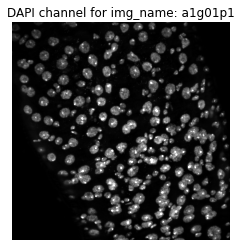

In [ ]:
import matplotlib.pyplot as plt

# display the DAPI channel for the first image
ax = plt.subplots()[1]
ax.imshow(
    exp.image_data["images"].sel(img_channels="C0", img_name="a1g01p1").compute(),
    cmap="gray",
    vmax=12000,
)
ax.set_title("DAPI channel for img_name: a1g01p1")
ax.set_axis_off()

We can add **segmentations** in the same fashion...

**TIP.** 
At a minimum, py_clone_detector requires a segmentation for the "tot_seg_ch" (see above for definition). If you do not have a suitable segmentation, check out the [example tutorial using StarDist](https://morriso1.github.io/py_clone_detective/Tutorial_StarDist_segmentation.html).

In [ ]:
exp.add_segmentations(C0="data/MARCM_experiment/segmentations/C0_stardist_segs/*.tif")

Segmentations have now been added to the Xarray dataset:

In [ ]:
exp.image_data

,Array,Chunk
Bytes,335.38 MiB,1.25 MiB
Shape,"(4, 67, 810, 810)","(1, 1, 810, 810)"
Count,1072 Tasks,268 Chunks
Type,uint16,numpy.ndarray
,Array,Chunk
Bytes,83.84 MiB,1.25 MiB
Shape,"(1, 67, 810, 810)","(1, 1, 810, 810)"
Count,335 Tasks,67 Chunks
Type,uint16,numpy.ndarray


### Measure cell properties

We next need to measure properties of each segmented cell (label) within our images:

In [ ]:
exp.make_measurements()

Without providing an arguments, `CloneCounter.make_measurements()` defaults to pairing the 'tot_seg_ch' segmentation channel to each of the image channels.

The segmentation-image channel pairs used for cell measurements can be accessed via the `CloneCounter.seg_img_channel_pairs` attribute.

In [ ]:
exp.seg_img_channel_pairs

,segmentation_channel,image_channel
0,C0,C0
1,C0,C1
2,C0,C2
3,C0,C3


**TIP:**
If these segmentation-image channel pairs are unsuitable for your experiment, they can be customised as detailed in the advanced tutorial (coming soon).

**TIP:**
As a default,`CloneCounter.make_measurements()` calculates every cell's mean intensity, centroid, and area. If we require additional measurements, we can supply the `extra_properties` with a list containing any 'regionprops' metrics from the [scikit-image measure module](https://scikit-image.org/docs/dev/api/skimage.measure.html). For example, we can additionally calculate 'eccentricity' as follows:

In [ ]:
exp.make_measurements(extra_properties=["eccentricity"])

The primary result from the `CloneCounter.make_measurements()` call is a `CloneCounter.results_measurements` attribute. This is a 'tidy' pandas DataFrame containing all per cell measurements.

In [ ]:
exp.results_measurements

,seg_ch,int_img_ch,seg_img,int_img,label,area,mean_intensity,centroid-0,centroid-1,eccentricity,area_um2
0,C0,C0,a1g01p1,a1g01p1,1,346,1144.604046,5.054913,97.182081,0.917838,26.166250
1,C0,C0,a1g01p1,a1g01p1,2,574,2557.510453,7.952962,223.238676,0.867292,43.408750
2,C0,C0,a1g01p1,a1g01p1,3,608,3160.207237,13.875000,519.351974,0.515510,45.980000
3,C0,C0,a1g01p1,a1g01p1,4,173,2825.052023,7.283237,644.699422,0.635806,13.083125
4,C0,C0,a1g01p1,a1g01p1,5,168,2858.904762,5.690476,385.523810,0.863300,12.705000
...,...,...,...,...,...,...,...,...,...,...,...
289,C0,C3,a2g13p3,a2g13p3,290,613,96.443719,792.845024,551.652529,0.499582,46.358125
290,C0,C3,a2g13p3,a2g13p3,291,410,76.739024,794.009756,459.451220,0.377639,31.006250
291,C0,C3,a2g13p3,a2g13p3,292,675,31.414815,798.114074,786.000000,0.698885,51.046875
292,C0,C3,a2g13p3,a2g13p3,293,599,95.011686,799.739566,500.397329,0.690486,45.299375


### Testing out thresholds

We now aim to determine whether each cell resides inside or outside a "clone". To do this, we first define a 'threshold' that categorises whether a cell is GFP positive or negative. This can be as simple as "mean_intensity > 1000", or involve multiple conditions e.g. "mean_intensity > 1000 & eccentricity > 0.3".

**N.B.** The threshold in this example is not being applied directly to the C1 image. Instead, for every label of the total segmentation channel (in this case C0: DAPI), we look at its corresponding intensity in the C1 (GFP) channel. We do this by querying the `CloneCounter.results_measurement` dataframe and keeping only those labels that meet our desired threshold criteria. 

The `CloneCounter` class provides a helper method `testing_possible_thresholds` that can plot and compare different thresholds:

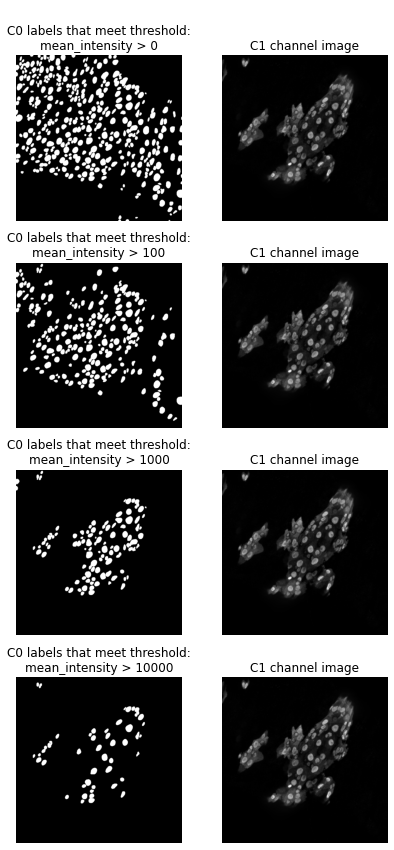

In [ ]:
exp.testing_possible_thresholds(
    int_img="a1g10p1",
    int_img_ch="C1",
    seg_img_ch="C0",
    threshold_list=[0, 100, 1000, 10000],
    threshold_query="mean_intensity > threshold_list",
)

From this test, we can see that a mean intensity threshold of 1000 appears roughly suitable, as its binary image on the left keeps most of the GFP positive cells, while excluding GFP negative cells.

If we were still unhappy with this as a simple threshold, we could increase stringency by adding another threshold on a different cell measurement. Below, we keep a mean intensity threshold constant at 1000, while varying an additional eccentricity threshold:

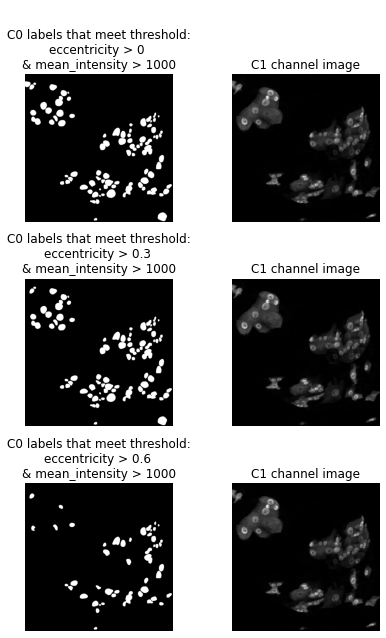

In [ ]:
exp.testing_possible_thresholds(
    int_img="a1g01p1",
    int_img_ch="C1",
    seg_img_ch="C0",
    threshold_list=[0, 0.3, 0.6],
    threshold_constant=1000,
    threshold_query="eccentricity > threshold_list & mean_intensity > threshold_constant",
)

In this example, most cells are pretty round and so both eccentricity == 0 and eccentricity == 0.3 look suitable.

### Add clones and calculate the number of touching neighbours

Once we have decided on a threshold, we can plug it into the `CloneCounter.add_clones_and_neighbouring_labels` method and apply it to all images:

In [ ]:
exp.add_clones_and_neighbouring_labels(
    query_for_pd='int_img_ch == "C1" & seg_ch == "C0" & eccentricity > 0.3 & mean_intensity > 1000',
    name_for_query="GFP",
    calc_clones=True,
)

This method call does a couple of things:

1) It updates CloneCounter.results_measurements with an additional boolean column describing whether a cell (label) is positive or negative for the desired threshold.

In [ ]:
exp.results_measurements.head()

,seg_ch,int_img_ch,seg_img,int_img,label,area,mean_intensity,centroid-0,centroid-1,eccentricity,area_um2,GFP_pos
0,C0,C0,a1g01p1,a1g01p1,1,346,1144.604046,5.054913,97.182081,0.917838,26.16625,False
1,C0,C1,a1g01p1,a1g01p1,1,346,66.199422,5.054913,97.182081,0.917838,26.16625,False
2,C0,C2,a1g01p1,a1g01p1,1,346,777.419075,5.054913,97.182081,0.917838,26.16625,False
3,C0,C3,a1g01p1,a1g01p1,1,346,44.170520,5.054913,97.182081,0.917838,26.16625,False
4,C0,C0,a1g01p1,a1g01p1,2,574,2557.510453,7.952962,223.238676,0.867292,43.40875,False


2) It adds new neighbourhood count and clone images to `CloneCounter.image_data`. (See the additional 'C1' data variable in the Xarray dataset below)

In [ ]:
exp.image_data

,Array,Chunk
Bytes,335.38 MiB,1.25 MiB
Shape,"(4, 67, 810, 810)","(1, 1, 810, 810)"
Count,1072 Tasks,268 Chunks
Type,uint16,numpy.ndarray
,Array,Chunk
Bytes,83.84 MiB,1.25 MiB
Shape,"(1, 67, 810, 810)","(1, 1, 810, 810)"
Count,335 Tasks,67 Chunks
Type,uint16,numpy.ndarray
,Array,Chunk


To illustrate what these new images are, lets plot and walkthrough them for a particular `img_name`. As all these new images derive from the original total segmentation image, we will plot this as well

Below is a little function to help with plotting:

In [ ]:
def plot_new_images(
    images, label_letter, label_text, figure_shape, colorbar=False, **kwargs,
):
    from itertools import zip_longest

    fig, ax = plt.subplots(
        nrows=figure_shape[0],
        ncols=figure_shape[1],
        figsize=(figure_shape[1] * 4, figure_shape[0] * 4),
    )

    for (img, ax, letter, text) in zip_longest(
        images, ax.flatten(), label_letter, label_text
    ):
        if img is not None:
            im = ax.imshow(img, **kwargs)
            ax.set_title(f"({letter}) {text}")
            ax.axis("off")
        else:
            ax.set_axis_off()
    if colorbar:
        fig2, cax = plt.subplots(figsize=(figure_shape[1], 1))
        plt.colorbar(im, cax=cax, orientation="horizontal")
        cax.set_title("number of neighbours")
        fig.axes.append(cax)

    plt.tight_layout()

Now lets grab and plot the total segmenatation image and new images for `img_name` = 'a1g01p1'.

In [ ]:
import numpy as np

# grab one img_name from dataset
img = exp.image_data.sel(img_name="a1g01p1")

# concentenate both the total segmentation and the new images for easy plotting
img_to_plot = np.concatenate(
    [img["segmentations"].data.compute(), img["GFP"].data.compute()]
)

# create text labels for our plot
text_labels = ["total_segmentation"] + img["GFP"].coords[
    "GFP_neighbours"
].values.tolist()

In [ ]:
# generate random colormap to help display label images
import matplotlib

colors = np.random.rand(256, 3)
colors[0, :] = 0
new_map = matplotlib.colors.LinearSegmentedColormap.from_list("new_map", colors)

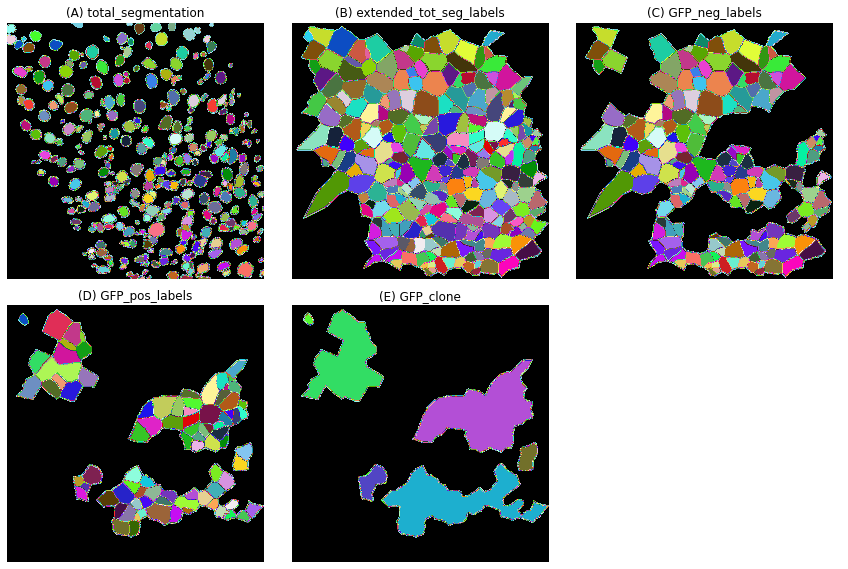

In [ ]:
plot_new_images(
    img_to_plot[:5], "ABCDE", text_labels[:5], figure_shape=(2, 3), cmap=new_map
)

(A) - total segmentation image i.e. from `exp.image_data['segmentations']`.  
(B) - labels of total segmentation image have been extended so they touch each other.  
(C) - labels that **did not** meet our threshold  (C1_neg_labels).  
(D) - labels that **did** meet our threshold  (C1_pos_labels).  
(E) - touching labels that did meet our threshold have been merged into 'clones'

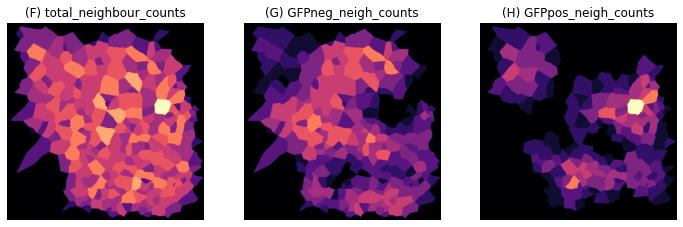

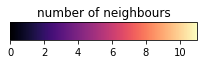

In [ ]:
plot_new_images(
    img_to_plot[5:],
    "FGH",
    text_labels[5:],
    (1, 3),
    vmax=np.unique(img_to_plot[5]).shape[0],
    colorbar=True,
    cmap="magma",
)

(F) - Parametric image where the number of total neighbours is mapped to color.  
(G) - Parametric image where the number of C1neg neighbours is mapped to color.  
(H) - Parametric image where the number of C1pos neighbours is mapped to color.

### Calculate number of touching neighbours for remaining non-clone image channels

As well as a GFP channel, our dataset contains fluorescence channels for PDM1 and Prospero immunostains. Since PDM1 (channel C2) markers EnteroCyte (EE) cells, and Prospero markers EnteroEndocrine (EE) cells, we can use thresholds to define these cell types within our images.

**EnteroCytes**  are large, absorptive cells within the intestine:

In [ ]:
exp.results_measurements = exp.results_measurements.eval(
    "total_intensity = mean_intensity * area"
)

In [ ]:
exp.add_clones_and_neighbouring_labels(
    query_for_pd='int_img_ch == "C2" & seg_ch == "C0" & total_intensity > 5e5',
    name_for_query="EC",
    calc_clones=False,
)

In [ ]:
exp.add_clones_and_neighbouring_labels(
    query_for_pd='int_img_ch == "C2" & seg_ch == "C0" & total_intensity < 5e5 & area_um2 > 50',
    name_for_query="preEC",
    calc_clones=False,
)

In [ ]:
exp.add_clones_and_neighbouring_labels(
    query_for_pd='int_img_ch == "C3" & seg_ch == "C0" & mean_intensity > 5000',
    name_for_query="EE",
    calc_clones=False,
)

In [ ]:
exp.add_clones_and_neighbouring_labels(
    query_for_pd='int_img_ch == "C2" & seg_ch == "C0" & total_intensity < 5e5 & area_um2 < 50',
    name_for_query="ISC_or_EB",
    calc_clones=False,
)

In [ ]:
df = exp.results_measurements

In [ ]:
df.query("EC_pos == EE_pos == True")

,seg_ch,int_img_ch,seg_img,int_img,label,area,mean_intensity,centroid-0,centroid-1,eccentricity,area_um2,C1_pos,total_intensity,EC_pos,preEC_pos,EE_pos,ISC_or_EB_pos
276,C0,C0,a1g01p1,a1g01p1,70,633,5179.017378,246.238547,677.533965,0.840966,47.870625,True,3278318.0,True,False,True,False
277,C0,C1,a1g01p1,a1g01p1,70,633,5321.210111,246.238547,677.533965,0.840966,47.870625,True,3368326.0,True,False,True,False
278,C0,C2,a1g01p1,a1g01p1,70,633,1456.003160,246.238547,677.533965,0.840966,47.870625,True,921650.0,True,False,True,False
279,C0,C3,a1g01p1,a1g01p1,70,633,5870.906793,246.238547,677.533965,0.840966,47.870625,True,3716284.0,True,False,True,False
560,C0,C0,a1g01p1,a1g01p1,141,882,5170.695011,419.170068,119.404762,0.582299,66.701250,False,4560553.0,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76699,C0,C3,a2g09p3,a2g09p3,65,368,6457.035326,201.076087,315.375000,0.827675,27.830000,False,2376189.0,True,False,True,False
78696,C0,C0,a2g10p2,a2g10p2,41,654,4658.697248,277.941896,733.157492,0.773488,49.458750,False,3046788.0,True,False,True,False
78697,C0,C1,a2g10p2,a2g10p2,41,654,87.758410,277.941896,733.157492,0.773488,49.458750,False,57394.0,True,False,True,False
78698,C0,C2,a2g10p2,a2g10p2,41,654,1997.519878,277.941896,733.157492,0.773488,49.458750,False,1306378.0,True,False,True,False


### Measure clone and the touching neighbours

In [ ]:
exp.measure_clones_and_neighbouring_labels(name_for_query="C1")
exp.measure_clones_and_neighbouring_labels(name_for_query="C2")
exp.measure_clones_and_neighbouring_labels(name_for_query="C3")

df = exp.combine_neighbour_counts_and_measurements()

In [ ]:
df

C1_clone  C1neg_neigh_counts  C1pos_neigh_counts  \
int_img label                                                     
a1g01p1 11            0                   2                   2   
        11            0                   2                   2   
        11            0                   2                   2   
        11            0                   2                   2   
        12            0                   4                   0   
...                 ...                 ...                 ...   
a2g13p3 285           0                   3                   0   
        286           0                   3                   0   
        286           0                   3                   0   
        286           0                   3                   0   
        286           0                   3                   0   

               total_neighbour_counts  C2neg_neigh_counts  C2pos_neigh_counts  \
int_img label                                                                   
a1g01p1 11                          4                   1                   3   
        11                          4                   1                   3   
        11                          4                   1                   3   
        11                          4                   1                   3   
        12                          4                   1                   3   
...                               ...                 ...                 ...   
a2g13p3 285                         3                   2                   1   
        286                         3                   2                   1   
        286                         3                   2                   1   
        286                         3                   2                   1   
        286                         3                   2                   1   

               C3neg_neigh_counts  C3pos_neigh_counts seg_ch int_img_ch  ...  \
int_img label                                                            ...   
a1g01p1 11                      4                   0     C0         C0  ...   
        11                      4                   0     C0         C1  ...   
        11                      4                   0     C0         C2  ...   
        11                      4                   0     C0         C3  ...   
        12                      4                   0     C0         C0  ...   
...                           ...                 ...    ...        ...  ...   
a2g13p3 285                     3                   0     C0         C3  ...   
        286                     3                   0     C0         C0  ...   
        286                     3                   0     C0         C1  ...   
        286                     3                   0     C0         C2  ...   
        286                     3                   0     C0         C3  ...   

               area  mean_intensity  centroid-0  centroid-1  eccentricity  \
int_img label                                                               
a1g01p1 11      969     2266.725490   44.054696   89.552116      0.440881   
        11      969       54.444788   44.054696   89.552116      0.440881   
        11      969     2335.034056   44.054696   89.552116      0.440881   
        11      969       69.485036   44.054696   89.552116      0.440881   
        12     1305     3152.119540   53.590038  486.798467      0.465227   
...             ...             ...         ...         ...           ...   
a2g13p3 285     589      104.699491  771.521222  475.609508      0.768511   
        286     303     1171.554455  770.996700  673.689769      0.901226   
        286     303       32.201320  770.996700  673.689769      0.901226   
        286     303      740.323432  770.996700  673.689769      0.901226   
        286     303       94.749175  770.996700  673.689769      0.901226   

                area_um2  C1_pos  total_intens

### Data Wrangling and Plotting

In [ ]:
import pandas as pd
import scikit_posthocs as sp

from py_clone_detective import clone_analysis as ca

idx = pd.IndexSlice

In [ ]:
df = df[np.invert(df.eval("C2_pos == C3_pos == True"))]

In [ ]:
grouped_df = ca.query_df_groupby_by_clone_channel(
    df.query('int_img_ch == "C1"').reset_index(),
    queries={
        "Total": None,
        "C2negC3neg_C0area_less_than_50um2": "C2_pos == False & C3_pos == False & area_um2 <= 50",
        "C2negC3neg_C0area_greater_than_50um2": "C2_pos == False & C3_pos == False & area_um2 > 50",
        "C2_pos_count": "C2_pos == True",
        "C3_pos_count": "C3_pos == True",
    },
    clone_channel="C1_clone",
)

In [ ]:
grouped_df = (
    grouped_df.stack((1, 2))
    .loc[idx[:, :, "label", "count"]]
    .reset_index((2, 3), drop=True)
    .reset_index()
)

In [ ]:
grouped_df["genotype"] = grouped_df["int_img"].str.extract(r"(a\d)")

In [ ]:
percentage_df = grouped_df.eval(
    """
C2negC3neg_C0area_less_than_50um2 = C2negC3neg_C0area_less_than_50um2 / Total * 100
C2negC3neg_C0area_greater_than_50um2 = C2negC3neg_C0area_greater_than_50um2 / Total * 100
C2_pos_count = C2_pos_count / Total * 100
C3_pos_count = C3_pos_count / Total * 100
"""
)

In [ ]:
inside_clone = grouped_df.query("C1_clone != 0")
inside_clone_percentage = percentage_df.query("C1_clone != 0").fillna(0)

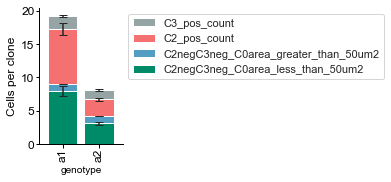

In [ ]:
ca.create_stack_bar_plot(
    inside_clone[
        [
            "genotype",
            "C2negC3neg_C0area_less_than_50um2",
            "C2negC3neg_C0area_greater_than_50um2",
            "C2_pos_count",
            "C3_pos_count",
        ]
    ]
    .groupby("genotype")
    .mean(),
    inside_clone[
        [
            "genotype",
            "C2negC3neg_C0area_less_than_50um2",
            "C2negC3neg_C0area_greater_than_50um2",
            "C2_pos_count",
            "C3_pos_count",
        ]
    ]
    .groupby("genotype")
    .sem(),
    x_figSize=1.5,
    color_pal=["#008b68", "#539DC2", "#F57171", "#95a5a6"],
    bar_width=0.8,
    y_label="Cells per clone",
    fp="../current_imaging_analysis/MARCM2A_E7F1_refactoring/screenshots/number.pdf",
)

In [ ]:
sp.posthoc_ttest(
    inside_clone,
    val_col="Total",
    group_col="genotype",
    pool_sd=True,
    p_adjust="holm-sidak",
)

,a1,a2
a1,1.000000e+00,7.747136e-13
a2,7.747136e-13,1.000000e+00


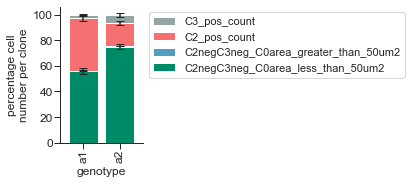

In [ ]:
ca.create_stack_bar_plot(
    inside_clone_percentage[
        [
            "genotype",
            "C2negC3neg_C0area_less_than_50um2",
            "C2negC3neg_C0area_greater_than_50um2",
            "C2_pos_count",
            "C3_pos_count",
        ]
    ]
    .groupby("genotype")
    .mean(),
    inside_clone_percentage[
        [
            "genotype",
            "C2negC3neg_C0area_less_than_50um2",
            "C2negC3neg_C0area_greater_than_50um2",
            "C2_pos_count",
            "C3_pos_count",
        ]
    ]
    .groupby("genotype")
    .sem(),
    x_figSize=1.5,
    color_pal=["#008b68", "#539DC2", "#F57171", "#95a5a6"],
    bar_width=0.8,
    y_label="percentage cell\nnumber per clone",
)

In [ ]:
sp.posthoc_ttest(
    inside_clone_percentage,
    val_col="C2negC3neg_C0area_less_than_50um2",
    group_col="genotype",
    pool_sd=True,
    p_adjust="holm-sidak",
)

,a1,a2
a1,1.000000e+00,1.165747e-08
a2,1.165747e-08,1.000000e+00
